In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alerce.core import Alerce
import psycopg2
import json
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_features = pd.read_parquet("data/features_labels.parquet")
df_test = pd.read_parquet ("data/test_set.parquet")
df_train = pd.read_parquet ("data/train_set.parquet")
df_train_ss = pd.read_parquet ("data/train_set_ss.parquet")

In [7]:
alerce_client = Alerce()

In [8]:
oid = 'ZTF20aaelulu'
light_curve = alerce_client.query_detections(oid, format='pandas')


In [9]:
for c in light_curve.columns:
    print (c)

tid
mjd
candid
fid
pid
diffmaglim
isdiffpos
nid
distnr
magpsf
magap
sigmapsf
sigmagap
ra
dec
rb
rbversion
drb
magapbig
sigmagapbig
rfid
has_stamp
corrected
dubious
step_id_corr
phase
parent_candid
magpsf_corr
sigmapsf_corr
sigmapsf_corr_ext


In [10]:
oids = [
    "ZTF18accqogs",
    "ZTF19aakyhxi",
    "ZTF19abyylzv",
    "ZTF19acyfpno",
]
objects = alerce_client.query_objects(oid=oids, format="pandas")

In [11]:
objects

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18accqogs,3,60,58426.228657,58426.231505,False,False,2,0.661297,NaN,...,58426.231505,0.002847,3.694674,-7.355086,0.000164,0.000146,None,None,None,corr_bulk_0.0.1
1,ZTF19aakyhxi,2,142,58538.172153,58562.130127,False,False,4,1.148241,NaN,...,58562.130127,23.957975,92.708387,35.647012,0.000026,0.000067,None,None,None,corr_bulk_0.0.1
2,ZTF19abyylzv,1,94,58741.337303,58741.337303,False,False,1,NaN,NaN,...,58741.337303,0.000000,335.804957,1.821680,NaN,NaN,None,None,None,corr_bulk_0.0.1
3,ZTF19acyfpno,4,489,58819.151076,58830.232905,True,False,4,0.358120,0.510152,...,58830.232905,11.081829,30.456234,29.104072,0.000051,0.000057,None,None,None,corr_bulk_0.0.1


In [12]:
for c in objects.columns:
    print (c)

oid
ndethist
ncovhist
mjdstarthist
mjdendhist
corrected
stellar
ndet
g_r_max
g_r_max_corr
g_r_mean
g_r_mean_corr
firstmjd
lastmjd
deltajd
meanra
meandec
sigmara
sigmadec
class
classifier
probability
step_id_corr


In [344]:
credentials_file = "alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

OperationalError: connection to server at "54.205.99.47", port 5432 failed: Network is unreachable
	Is the server running on that host and accepting TCP/IP connections?


In [345]:
# %%time
# base_query = """SELECT oid, ra ,dec, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr, sigmapsf_corr_ext, rb, corrected
#     FROM detection  
#     WHERE oid IN (%s)"""

# batch = pd.concat((df_train_ss["oid"], df_test["oid"])).values[:1000]
# #batch = df_train_ss["oid"].values
# batch = [f"'{o}'" for o in batch]
# batch = ",".join(batch)

# query = base_query % batch

# df_lightcurves = pd.read_sql(query, conn)

In [346]:
# If you do not have the data, this takes between 1 and 2 hours to run
%%time

base_query = """SELECT oid, ra ,dec, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr, sigmapsf_corr_ext, rb, corrected
    FROM detection  
    WHERE oid IN (%s)"""
df_lightcurves = pd.DataFrame (columns= ["oid", "ra" ,"dec", "mjd", "fid", "magpsf", "sigmapsf", 
                              "magpsf_corr", "sigmapsf_corr", "sigmapsf_corr_ext", 
                              "rb", "corrected"])

for i, batch in enumerate(np.array_split (pd.concat((df_train_ss["oid"], df_test["oid"])).values, 30)):
    print (i, batch.shape)
    #batch = pd.concat((df_train_ss["oid"], df_test["oid"])).values[:1000]
    #batch = df_train_ss["oid"].values
    fn = "data/lightcurves_" + str(i) + "_" + str(len(batch)) + ".parquet"
    if os.path.exists (fn):
        #df_lightcurves = pd.concat ([df_lightcurves, pd.read_parquet(fn)])
        df_lightcurves = pd.read_parquet(fn)
        print (fn + " read")
        continue

    batch = [f"'{o}'" for o in batch]
    batch = ",".join(batch)

    query = base_query % batch

    #df_lightcurves = pd.concat ([df_lightcurves, pd.read_sql(query, conn)])
    df_lightcurves = pd.read_sql(query, conn)
    df_lightcurves.to_parquet (fn)

UsageError: Line magic function `%%time` not found.


In [105]:
filename = "data/lightcurves.parquet"

if os.path.exists (filename):
    df_lightcurves = pd.read_parquet (filename)
else:
    df_lightcurves = pd.DataFrame (columns= ["oid", "ra" ,"dec", "mjd", "fid", "magpsf", "sigmapsf", 
                                  "magpsf_corr", "sigmapsf_corr", "sigmapsf_corr_ext", 
                                  "rb", "corrected"])

    # concatenate the data
    for i, batch in enumerate(np.array_split (pd.concat((df_train_ss["oid"], df_test["oid"])).values, 30)):
        print (i, batch.shape)
        fn = "data/lightcurves_" + str(i) + "_" + str(len(batch)) + ".parquet"
        df_file = pd.read_parquet(fn)

        df_lightcurves = pd.concat ([df_lightcurves, df_file])
    df_lightcurves.to_parquet ("lightcurves.parquet")

In [106]:
df_lightcurves = df_lightcurves.reset_index()

In [107]:
# filename = './data/lightcurves_0_2498.parquet'
# df_lightcurves = pd.read_parquet (filename)
# df_lightcurves.head()

In [108]:
df_lightcurves.shape

(16823968, 13)

In [109]:
df_lightcurves['corrected'] = df_lightcurves['corrected'].astype('bool')


In [110]:
df_lightcurves['corrected'].value_counts()

True     16672142
False      151826
Name: corrected, dtype: int64

In order to avoid spurious points in the light curves, we removed observations with a ZTF real-bogus score lower than 0.55, magnitude errors higher than 1, or magnitudes higher than 23. We used the corrected light curves  to take into account the use of difference image fluxes as described in Sanchez et.al. 2021.

In [111]:
df_lightcurves

,index,oid,ra,dec,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,rb,corrected
0,0,ZTF17aaapukq,177.366572,14.333978,58636.247350,1,19.764230,0.138408,17.350574,0.004586,0.014987,0.910000,True
1,1,ZTF17aaapukq,177.366666,14.333960,58639.175787,2,19.352100,0.211374,17.330643,0.029936,0.032845,0.601429,True
2,2,ZTF17aaapukq,177.366628,14.333984,58653.187072,2,19.153150,0.131968,17.297235,0.019968,0.023884,0.928571,True
3,3,ZTF17aaapukq,177.366619,14.333919,58658.178160,2,19.194826,0.181321,17.304659,0.028930,0.031797,0.735714,True
4,4,ZTF17aaapukq,177.366719,14.333855,58658.192824,1,19.594015,0.133610,17.330803,0.008936,0.016617,0.840000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16823963,539805,ZTF20abbpows,283.126455,40.318581,59366.307072,1,20.553555,0.209635,19.929937,0.110820,0.118036,0.862857,True
16823964,539806,ZTF20abbpows,283.126625,40.318532,59670.476273,2,20.299600,0.236194,19.533855,0.110533,0.116673,0.694286,True
16823965,539807,ZTF20abbpows,283.126451,40.318496,59670.501667,1,20.952700,0.341988,19.756498,0.108232,0.113640,0.835714,True
16823966,539808,ZTF20abbpows,283.126482,40.318537,59675.494618,1,20.553300,0.280371,19.930080,0.152603,0.157923,0.765714,True


In [112]:
# Filter for ZTF's real-bogus score
df_lightcurves = df_lightcurves[df_lightcurves['rb'] >= 0.55]

# Select magnitudes and errors based on whether they were corrected or not
df_lightcurves['mag'] = df_lightcurves['magpsf_corr']
df_lightcurves['err'] = df_lightcurves['sigmapsf_corr_ext']
df_lightcurves['mag'][~df_lightcurves['corrected']] = df_lightcurves['magpsf'][~df_lightcurves['corrected']]
df_lightcurves['err'][~df_lightcurves['corrected']] = df_lightcurves['sigmapsf'][~df_lightcurves['corrected']]

# Filter for magnitude and their errors 
df_lightcurves = df_lightcurves[(df_lightcurves['err'] < 1) & (df_lightcurves['mag'] < 23)]


In [113]:
def fn(x):
    ret = x[["mjd", "mag", "err", "fid"]].values.transpose()
    ret[0] = ret[0] - np.min(ret[0])
    return ret


In [115]:
df_lightcurves = df_lightcurves.groupby ("oid").apply (lambda x: fn(x)).reset_index()

In [116]:
df_lightcurves

,oid,0
0,ZTF17aaaaasi,"[[0.0, 1.0057291998527944, 1.9984144000336528,..."
1,ZTF17aaaaast,"[[0.0, 2.0370717998594046, 11.9921875, 14.9962..."
2,ZTF17aaaaasx,"[[0.0, 0.9889120999723673, 6.1132871001027524,..."
3,ZTF17aaaaatf,"[[0.0, 0.9986574002541602, 2.0008912002667785,..."
4,ZTF17aaaaavq,"[[0.0, 0.9787037000060081, 1.0063542001880705,..."
...,...,...
74925,ZTF20abcvfqq,"[[0.0, 14.867198999971151, 15.939016200136393,..."
74926,ZTF20abcvfvi,"[[0.0, 10.845370300114155, 10.851817100308836,..."
74927,ZTF20abcvfwc,"[[0.0, 11.957835599780083, 13.875729199964553,..."
74928,ZTF20abcvgqu,"[[0.0, 11.975567099638283, 13.047384299803525,..."


In [117]:
df_lightcurves= df_lightcurves.rename(columns={0: "data"})

In [119]:
for d in df_lightcurves['data'][100][0]:
    print (d)

0.0
0.04140039999037981
5.8764582998119295
5.91832169983536
11.958124999888241
11.996064799837768
15.952974499668926
15.975277699995786
21.89054389996454
21.916736099869013
25.94956019986421
36.868113399948925
39.87173609994352
42.87356479978189
55.89217589981854
58.87048609973863
58.9140625
72.8501967000775
72.89064810005948
75.84635409992188
83.81295139994472
83.83451389987022
91.77641199994832
109.76876149978489
109.82981480006129
122.79245369974524
131.77865740004927
131.8298378996551
272.1159605998546
272.1437152000144
275.11974529968575
275.15266199968755
283.1264003999531
283.1608679997735
286.1414814000018
286.16265039984137
289.1178472000174
289.1469675996341
290.13246520003304
294.1056596999988
297.10567129962146
297.1457753996365
298.1203239997849
300.0852545998059
300.1564583000727
306.08539350004867
306.1440392998047
309.1442476999946
311.1083911997266
313.08206019969657
319.1028239997104
325.004814799875
325.07872679969296
326.10364579968154
327.1080092000775
328.16251150

In [120]:
# Add labels
df_labels = pd.read_csv ("data/labeled_set_lc_classifier_SanchezSaez_2020.csv")
df_lightcurves = df_lightcurves.merge(df_labels[["oid", "classALeRCE"]], how = "inner", right_on="oid", left_on='oid')


In [121]:
df_lightcurves

,oid,data,classALeRCE
0,ZTF17aaaaasi,"[[0.0, 1.0057291998527944, 1.9984144000336528,...",LPV
1,ZTF17aaaaast,"[[0.0, 2.0370717998594046, 11.9921875, 14.9962...",LPV
2,ZTF17aaaaasx,"[[0.0, 0.9889120999723673, 6.1132871001027524,...",LPV
3,ZTF17aaaaatf,"[[0.0, 0.9986574002541602, 2.0008912002667785,...",LPV
4,ZTF17aaaaavq,"[[0.0, 0.9787037000060081, 1.0063542001880705,...",LPV
...,...,...,...
74925,ZTF20abcvfqq,"[[0.0, 14.867198999971151, 15.939016200136393,...",QSO
74926,ZTF20abcvfvi,"[[0.0, 10.845370300114155, 10.851817100308836,...",QSO
74927,ZTF20abcvfwc,"[[0.0, 11.957835599780083, 13.875729199964553,...",QSO
74928,ZTF20abcvgqu,"[[0.0, 11.975567099638283, 13.047384299803525,...",QSO


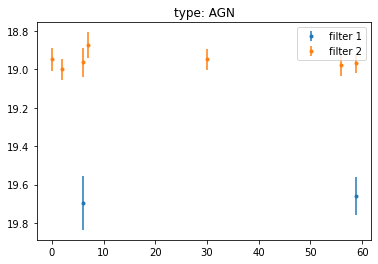

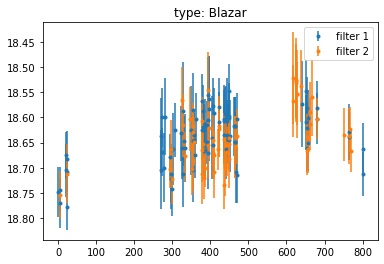

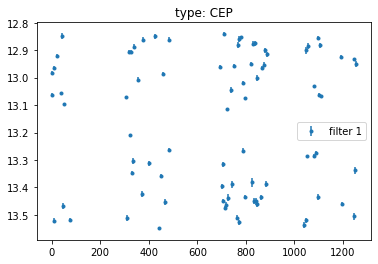

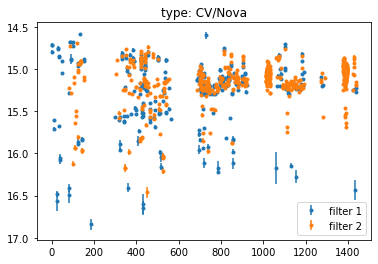

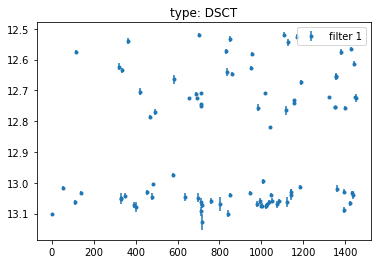

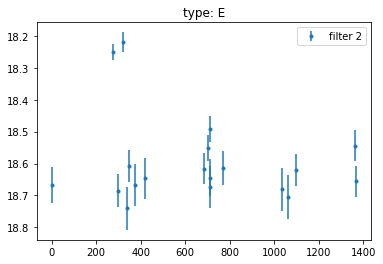

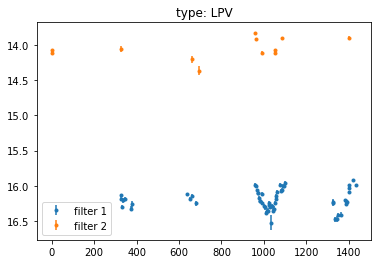

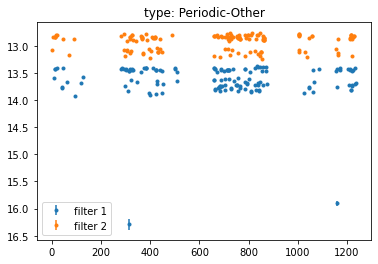

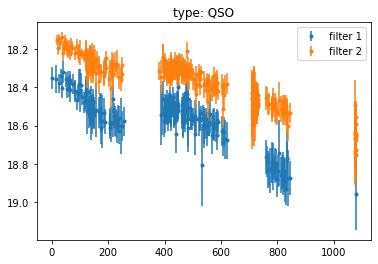

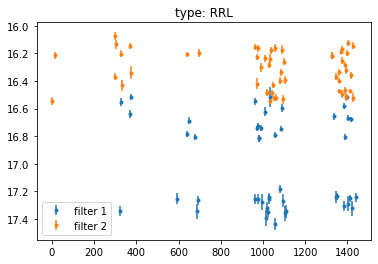

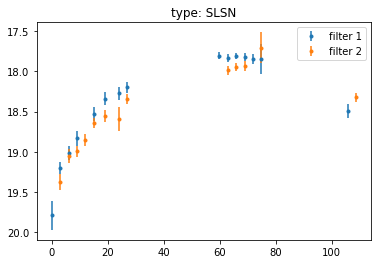

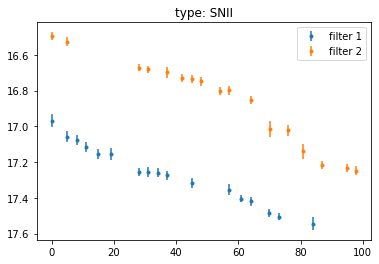

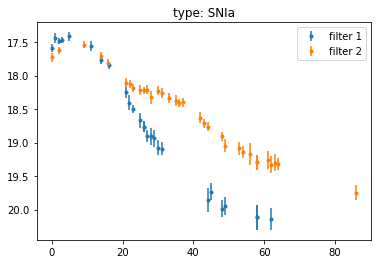

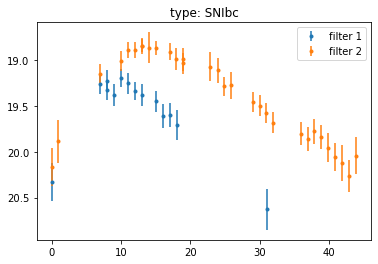

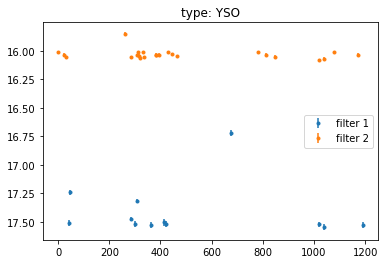

In [122]:
for i, r in df_lightcurves.groupby('classALeRCE').apply(lambda x: x.sample(1)).iterrows():
    for fid in np.unique(r['data'][3]):
        plt.errorbar(r['data'][0][r['data'][3] == fid], 
                     r['data'][1][r['data'][3] == fid], 
                     yerr = r['data'][2][r['data'][3] == fid], 
                     label = "filter " + str(int(fid)), ls = "", marker = ".")
    plt.title("type: " + r['classALeRCE'])
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

<AxesSubplot:title={'center':'dataset'}>

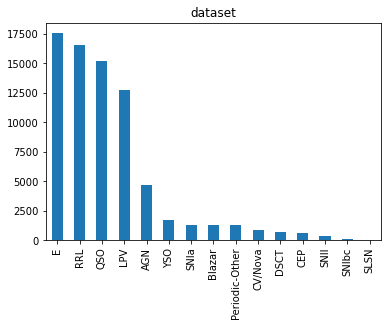

In [123]:
df_lightcurves['classALeRCE'].value_counts().plot(kind='bar', title = "dataset")

## Data preprocessing using tf.Data

In [124]:
INP_DIM = 4 # Number of attributes e.g., mjd, magnitudes, errors...
NUM_CLS = len(df_lightcurves['classALeRCE'].unique())
BATCH_SIZE = 128 # Training batch size

In [125]:
NUM_CLS

15

In [126]:
len(df_lightcurves['classALeRCE'].unique())

15

In [127]:
labels = df_lightcurves['classALeRCE'].unique()
df_lightcurves['label'] = df_lightcurves['classALeRCE'].replace (labels, 
                                                      np.arange (NUM_CLS), 
                                                      inplace = False)

In [128]:
df_lightcurves

,oid,data,classALeRCE,label
0,ZTF17aaaaasi,"[[0.0, 1.0057291998527944, 1.9984144000336528,...",LPV,0
1,ZTF17aaaaast,"[[0.0, 2.0370717998594046, 11.9921875, 14.9962...",LPV,0
2,ZTF17aaaaasx,"[[0.0, 0.9889120999723673, 6.1132871001027524,...",LPV,0
3,ZTF17aaaaatf,"[[0.0, 0.9986574002541602, 2.0008912002667785,...",LPV,0
4,ZTF17aaaaavq,"[[0.0, 0.9787037000060081, 1.0063542001880705,...",LPV,0
...,...,...,...,...
74925,ZTF20abcvfqq,"[[0.0, 14.867198999971151, 15.939016200136393,...",QSO,9
74926,ZTF20abcvfvi,"[[0.0, 10.845370300114155, 10.851817100308836,...",QSO,9
74927,ZTF20abcvfwc,"[[0.0, 11.957835599780083, 13.875729199964553,...",QSO,9
74928,ZTF20abcvgqu,"[[0.0, 11.975567099638283, 13.047384299803525,...",QSO,9


In [129]:
def create_generator(list_of_arrays, labels):
    for i, j in zip(list_of_arrays, labels):
        yield {'lightcurve': i.transpose(),
               'label'     : int(j),
               'mask'      : np.ones(i.transpose().shape[0])}

In [130]:
def preprocess(input_dict):
    lc_means = tf.reduce_mean(input_dict['lightcurve'], 0)
    lc_std   = tf.math.reduce_std(input_dict['lightcurve'], 0)
    light_curve = tf.math.divide_no_nan(input_dict['lightcurve'] - tf.expand_dims(lc_means, 0), lc_std)
    
#     light_curve = input_dict['lightcurve'] - tf.expand_dims(lc_means, 0)
    
    cat_label   = tf.one_hot(input_dict['label'], NUM_CLS)
    bool_mask   = tf.cast(input_dict['mask'], tf.bool)
    return (light_curve, bool_mask), cat_label

In [131]:
# def create_dataset(light_curves, labels):
#     dataset = tf.data.Dataset.from_generator(lambda: create_generator(light_curves, labels),
#                                              output_types= {'lightcurve':tf.float32,
#                                                             'label':tf.int32,
#                                                             'mask':tf.int32},
#                                              output_shapes={'lightcurve':(None, INP_DIM),
#                                                             'label':(),
#                                                             'mask':(None)})
#     dataset = dataset.map(preprocess)
#     dataset = dataset.shuffle(1000) # shuffling in chunks of 1000 objects 
#     dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(([None, INP_DIM], [None]), [NUM_CLS]))
#     return dataset

In [132]:
def load_class_dataset(lightcurves, labels):
    dataset = tf.data.Dataset.from_generator(lambda: create_generator(lightcurves, labels),
                                             output_types= {'lightcurve':tf.float32,
                                                            'label':tf.int32,
                                                            'mask':tf.int32},
                                             output_shapes={'lightcurve':(None, INP_DIM),
                                                            'label':(),
                                                            'mask':(None)})
    return dataset

def create_dataset(light_curves, labels, balanced=False):
    if balanced:
        datasets = []
        for y in np.unique(labels):
            cls_samples = light_curves[labels==y]
            cls_labels  = labels[labels==y]
            datasets.append(load_class_dataset(cls_samples, cls_labels))
        dataset = tf.data.Dataset.sample_from_datasets(datasets)
    else:
        dataset = load_class_dataset(light_curves, labels)
        
    dataset = dataset.map(preprocess)
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True) # shuffling in chunks of 1000 objects 
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(([None, INP_DIM], [None]), [NUM_CLS]))
    return dataset

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
df_lightcurves.head()

,oid,data,classALeRCE,label
0,ZTF17aaaaasi,"[[0.0, 1.0057291998527944, 1.9984144000336528,...",LPV,0
1,ZTF17aaaaast,"[[0.0, 2.0370717998594046, 11.9921875, 14.9962...",LPV,0
2,ZTF17aaaaasx,"[[0.0, 0.9889120999723673, 6.1132871001027524,...",LPV,0
3,ZTF17aaaaatf,"[[0.0, 0.9986574002541602, 2.0008912002667785,...",LPV,0
4,ZTF17aaaaavq,"[[0.0, 0.9787037000060081, 1.0063542001880705,...",LPV,0


In [135]:
x_train, x_rest, \
y_train, y_rest = train_test_split(df_lightcurves['data'], df_lightcurves['label'], 
                                   test_size=0.2, random_state=53)

x_val, x_test, \
y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.2, random_state=53)

In [136]:
# x_train, x_rest, \
# y_train, y_rest = train_test_split(light_curves, labels_new, test_size=0.5, random_state=42)

# x_val, x_test, \
# y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)

In [137]:
x_train.iloc[0].transpose().shape

(444, 4)

In [138]:
train_batches = create_dataset(x_train, y_train, balanced = True) 
valid_batches = create_dataset(x_val, y_val)
test_batches  = create_dataset(x_test, y_test)

In [139]:
for (x,m), y in valid_batches:
    print(x.shape)
    print(m.shape)
    print(y.shape)
    break

(128, 1040, 4)
(128, 1040)
(128, 15)


## Long Short Term Memory

In [140]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [141]:
# # Params 
# n_neurons    = 16  # Neurons in each gate of LSTM
# dropout_prob = 0.2 # Fraction of the units to drop 

In [142]:
# Params 
n_neurons    = 32  # Neurons in each gate of LSTM
dropout_prob = 0.3 # Fraction of the units to drop 
num_layers   = 2

In [143]:
# lc_placeholder   = Input(shape=(None, INP_DIM), dtype=tf.float32)
# mask_placeholder = Input(shape=(None,), dtype=tf.bool)
# inputs = (lc_placeholder, mask_placeholder)

# x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs[0], mask=inputs[1])
# x = LSTM(n_neurons, dropout=dropout_prob)(x, mask=inputs[1])
# x = Dense(n_neurons, activation='relu')(x)
# predictions = Dense(NUM_CLS, activation='softmax')(x)

# model = Model(inputs=[inputs], outputs=predictions)
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# model.summary()

In [144]:
lc_placeholder   = Input(shape=(None, INP_DIM), dtype=tf.float32)
mask_placeholder = Input(shape=(None,), dtype=tf.bool)
inputs = (lc_placeholder, mask_placeholder)

cells = []
for i in range(num_layers):
    x = LSTM(n_neurons, dropout=dropout_prob)

rnn_network = tf.keras.layers.RNN(cells)

x = rnn_network(inputs[0], mask=inputs[1])
predictions = Dense(NUM_CLS, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 4)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 rnn (RNN)                      (None, 4)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 15)           75          ['rnn[0][0]']                

In [145]:
history = model.fit(x=train_batches, 
                    epochs=10,
                    validation_data=valid_batches,
                    callbacks = [EarlyStopping(patience=5)])

Epoch 1/10
469/469 [==============================] - 26s 55ms/step - loss: 2.2196 - acc: 0.2356 - val_loss: 2.0525 - val_acc: 0.2653
Epoch 2/10
469/469 [==============================] - 22s 46ms/step - loss: 1.9763 - acc: 0.2801 - val_loss: 1.9630 - val_acc: 0.2809
Epoch 3/10
469/469 [==============================] - 21s 45ms/step - loss: 1.9396 - acc: 0.2907 - val_loss: 1.9440 - val_acc: 0.2998
Epoch 4/10
469/469 [==============================] - 21s 45ms/step - loss: 1.9298 - acc: 0.2985 - val_loss: 1.9352 - val_acc: 0.3056
Epoch 5/10
469/469 [==============================] - 25s 53ms/step - loss: 1.9237 - acc: 0.3016 - val_loss: 1.9303 - val_acc: 0.3073
Epoch 6/10
469/469 [==============================] - 21s 44ms/step - loss: 1.9193 - acc: 0.3026 - val_loss: 1.9277 - val_acc: 0.3073
Epoch 7/10
469/469 [==============================] - 21s 45ms/step - loss: 1.9169 - acc: 0.3042 - val_loss: 1.9239 - val_acc: 0.3071
Epoch 8/10
469/469 [==============================] - 26s 56ms

In [146]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_probas = model.predict(test_batches)
y_pred   = np.argmax(y_probas, axis=1)

y_test   = np.concatenate([y for _, y in test_batches], 0)
y_true   = np.argmax(y_test, axis=1)

acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

Accuracy:0.2208138759172782
F1:0.05273678772224922


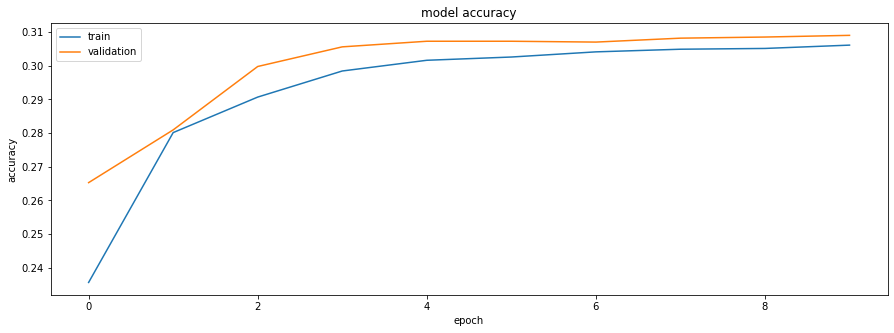

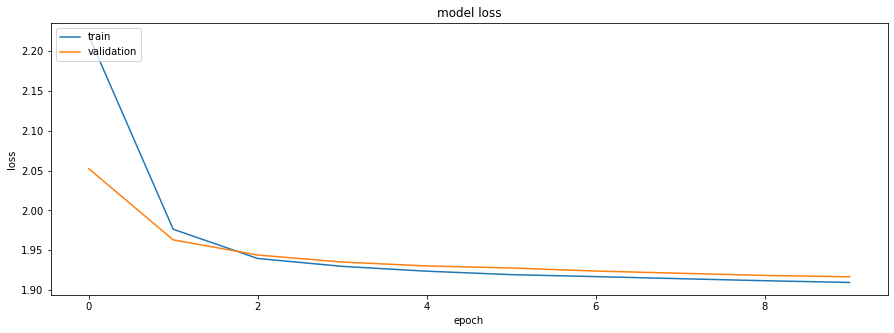

In [147]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

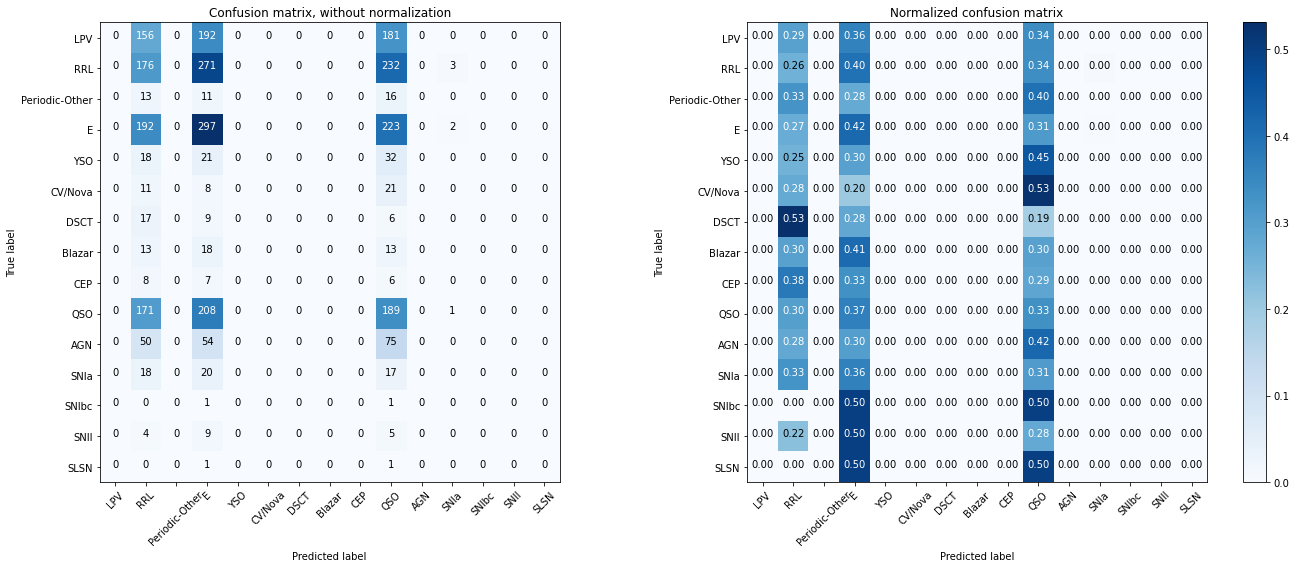

In [148]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix

class_names = labels
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')